In [1]:
from model.classification_model import ClassifierModel # class with classifiers
from model.reduce_model import ReduceModel # class with autoencoder

import numpy as np
import pandas as pd

from sklearn import metrics
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from plot_settings import * # plot configuration 

ide_plot() #plot for github dark theme

In [2]:
plt.rcParams["axes.facecolor"] = 'w'
plt.rcParams["figure.facecolor"] = 'w'
plt.rcParams['figure.dpi'] = 100
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.edgecolor"] = 'black'
plt.rcParams["xtick.color"] = 'black'
plt.rcParams["ytick.color"] = 'black'
plt.rcParams["axes.labelcolor"] = 'black'
plt.rcParams["grid.color"] = 'black'
plt.rcParams["legend.frameon"] = False
plt.rcParams["legend.labelcolor"] = 'black'
plt.rcParams["axes.titlecolor"] = 'black'
plt.rcParams['axes.prop_cycle'] = cycler(color=['g', 'r', 'b', 'y'])

In [3]:
# Load main dataset
dataset = pd.read_csv("main_datasets/dataset.csv", index_col=0)
target = pd.read_csv("main_datasets/target.csv", index_col=0)

In [4]:
reduce_model = ReduceModel(model="AE", layers=(1018, 300, 10))
reduce_model.train(epochs=80, lr=1e-3)

Sequential(
  (0): Linear(in_features=1018, out_features=300, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=300, out_features=10, bias=True)
)
Sequential(
  (0): Linear(in_features=10, out_features=300, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=300, out_features=1018, bias=True)
)


100%|██████████| 80/80 [00:25<00:00,  3.10it/s]

Epoch 80, Train Loss: 0.0015522374627873936
Epoch 80, Validation Loss: 0.0015825789014343172


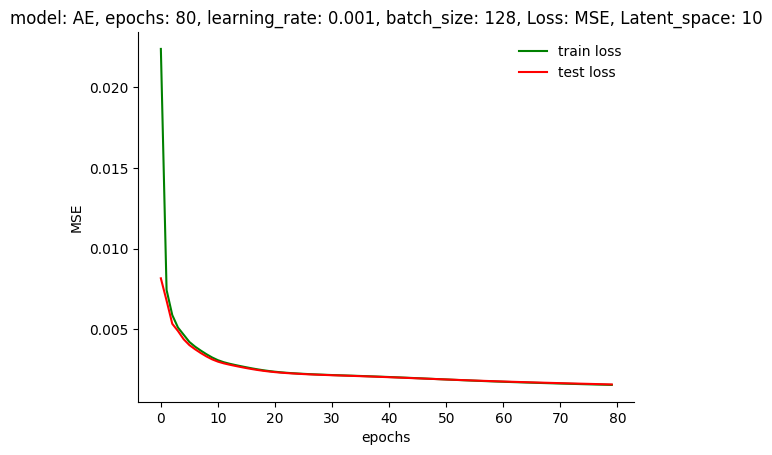

In [45]:
reduce_model.plot_loss()


In [6]:
main_reduced = reduce_model.transform(dataset)

In [7]:
qmof_reduced = reduce_model.transform(reduce_model.dataset.cpu())

In [8]:
main_reduced.shape

(102, 10)

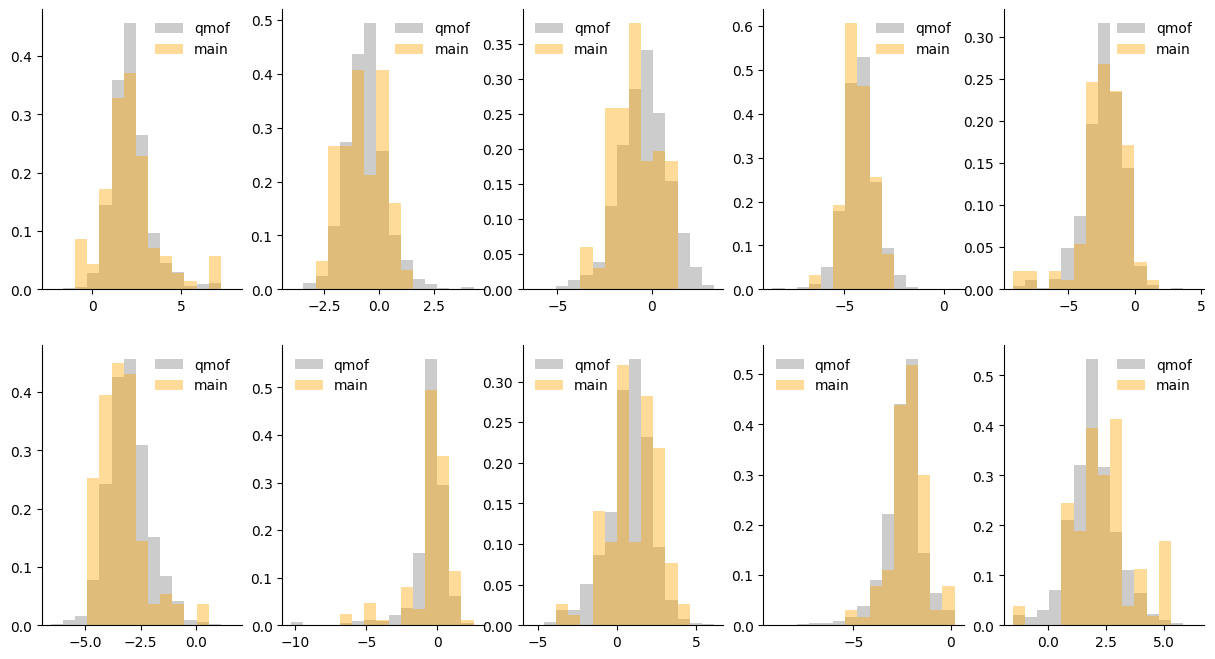

In [9]:
fig, axes = plt.subplots(2, 5, figsize=(15,8))
u = 0
for i in range(2):
    for h in range(5):
        v, bins, p = axes[i,h].hist(qmof_reduced[:, u], density=True, bins=15, alpha=0.4, label="qmof", color='gray')
        axes[i,h].hist(main_reduced[:, u], density=True, bins=bins, alpha=0.4, label="main", color='orange')
        axes[i,h].legend()
        u += 1
    

In [10]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import Normalizer


def plot_2d(x1, y1, name):
    x1 = Normalizer().transform(x1)
    figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9))
    tsne = TSNE(n_components=2, random_state=0)
    X_t = tsne.fit_transform(x1)

    pca = PCA(n_components=2, random_state=0)
    X_p = pca.fit_transform(x1)

    ax1.scatter(X_t[np.where(y1 == 0), 0], X_t[np.where(y1 == 0), 1], marker='o', color='#088466', linewidth=1, alpha=0.8, label='0')
    ax1.scatter(X_t[np.where(y1 == 1), 0], X_t[np.where(y1 == 1), 1], marker='o', color='#fdfe66', linewidth=1, alpha=0.8, label='1')
    ax1.set_title(f"TSNE: {name}")

    ax2.scatter(X_p[np.where(y1 == 0), 0], X_p[np.where(y1 == 0), 1], marker='o', color='#088466', linewidth=1, alpha=0.8, label='0')
    ax2.scatter(X_p[np.where(y1 == 1), 0], X_p[np.where(y1 == 1), 1], marker='o', color='#fdfe66', linewidth=1, alpha=0.8, label='1')
    ax2.set_title(f"PCA: {name}")
    ax2.legend()

def plot_2d_proba(x1, y1_proba, name):
    figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9))
    tsne = TSNE(n_components=2, random_state=0)
    X_t = tsne.fit_transform(x1)

    pca = PCA(n_components=2, random_state=0)
    X_p = pca.fit_transform(x1)

    ax1.scatter(X_t[:, 0], X_t[:, 1], marker='o', color=y1_proba, linewidth=1, alpha=0.8, label='0')
    ax1.set_title(f"TSNE: {name}")

    ax2.scatter(X_p[:, 0], X_p[:, 1], marker='o', color=y1_proba, linewidth=1, alpha=0.8, label='0')
    ax2.set_title(f"PCA: {name}")
    ax2.legend()

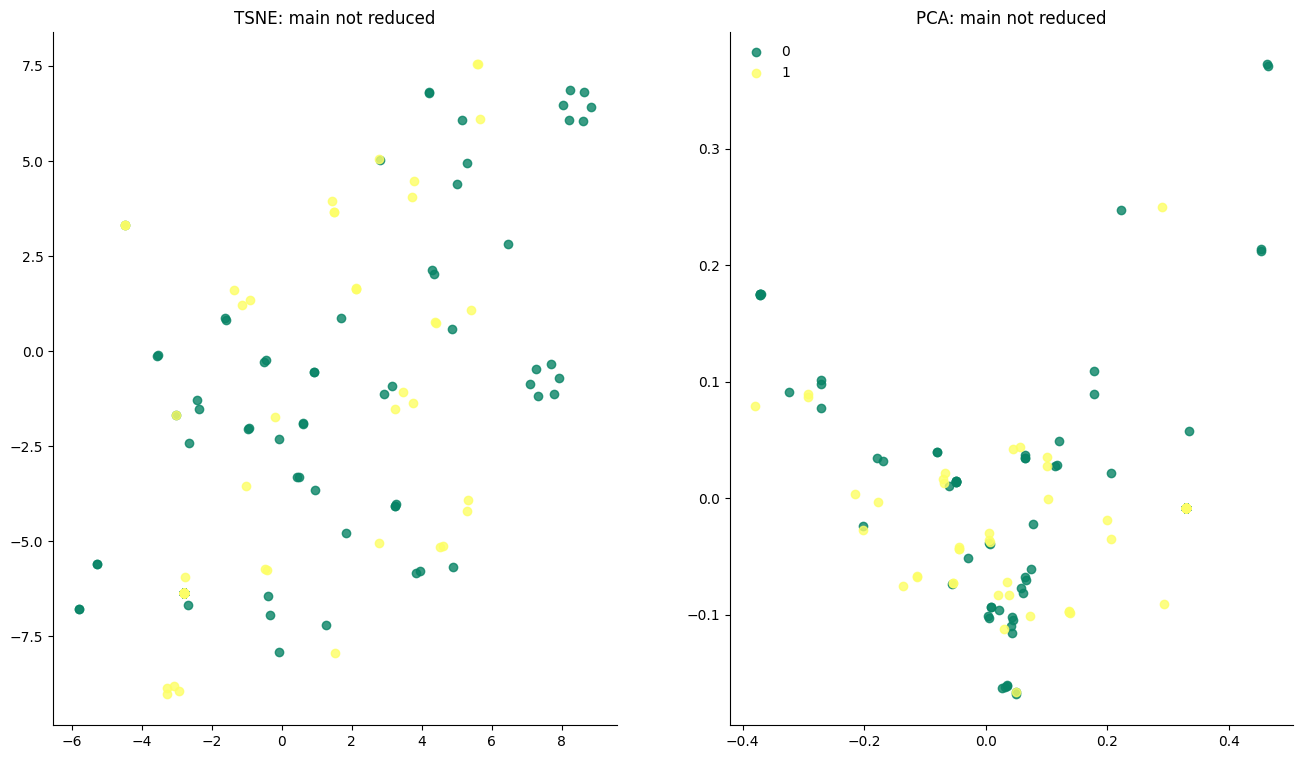

In [11]:
plot_2d(dataset.values, target, "main not reduced")

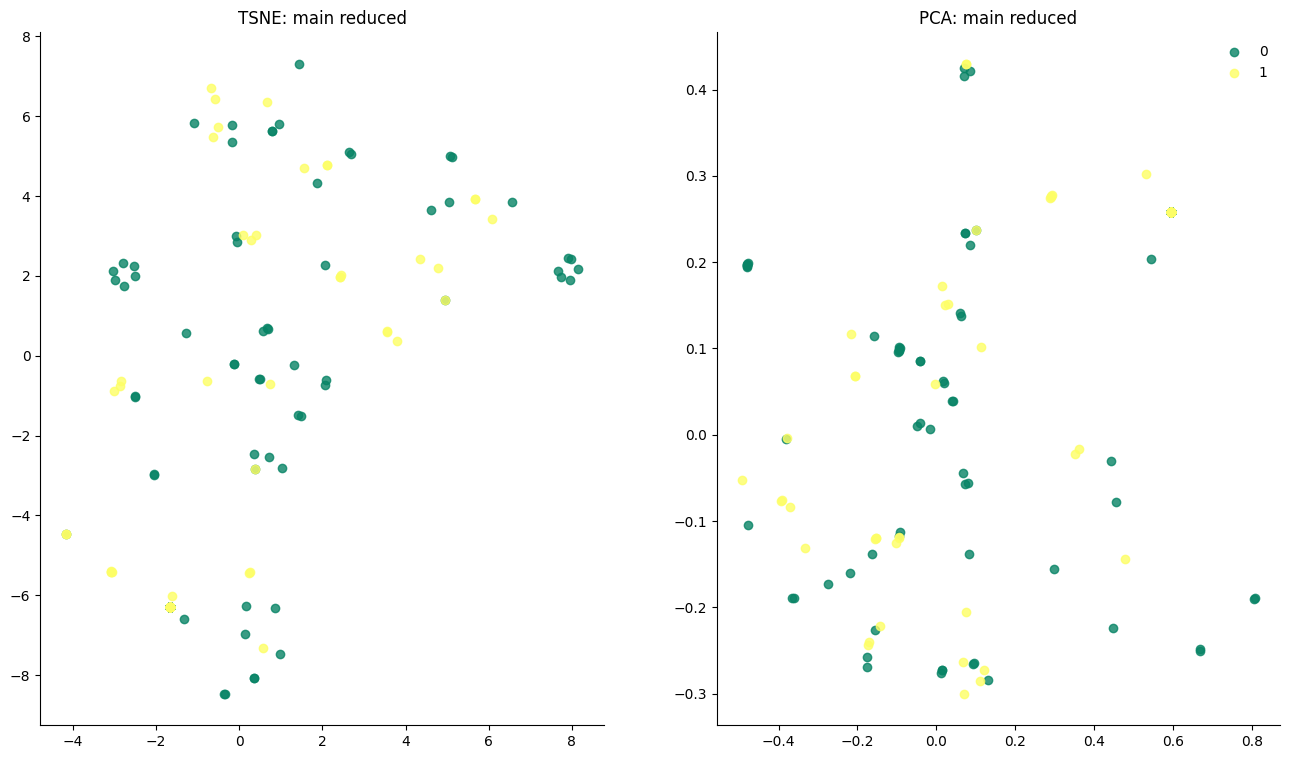

In [37]:
plot_2d(main_reduced, target, "main reduced")

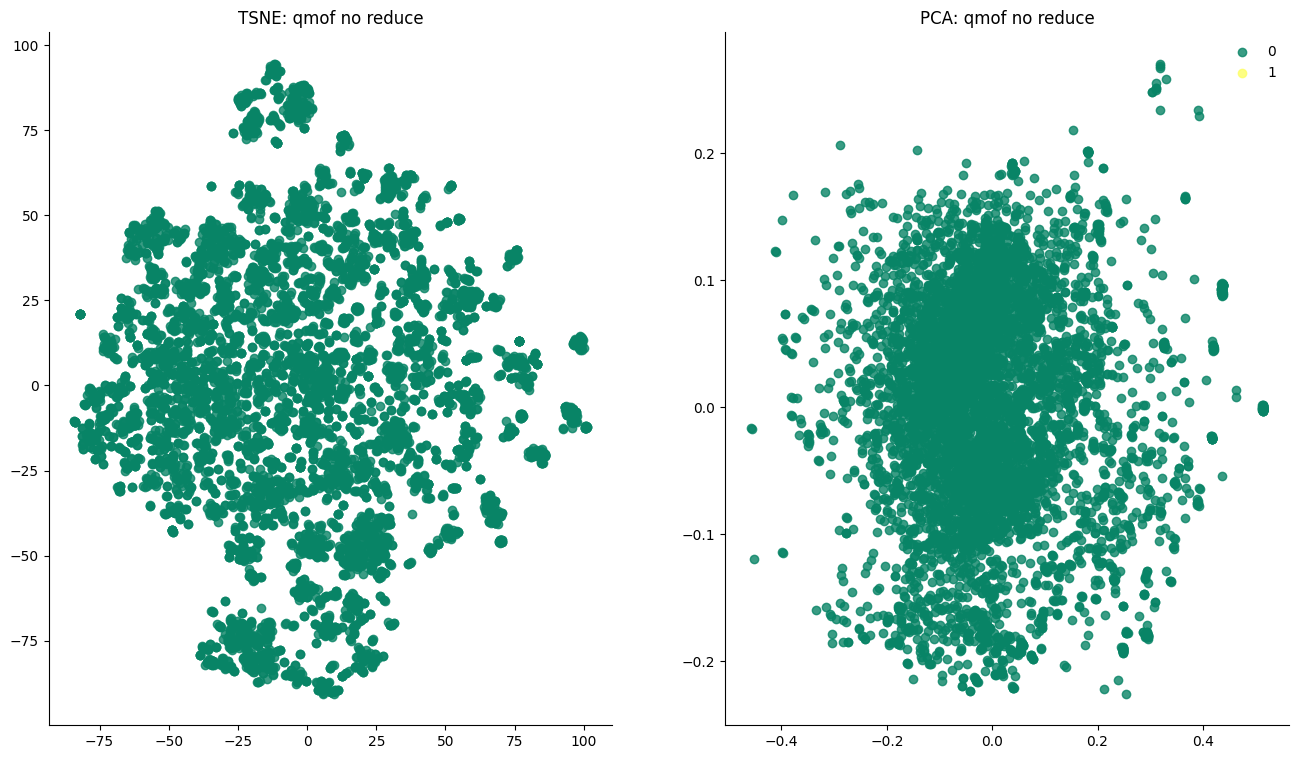

In [38]:
plot_2d(reduce_model.dataset.cpu(), np.zeros((reduce_model.dataset.cpu().shape[0])), "qmof no reduce")
plt.savefig("tsne_no_reduce.svg")

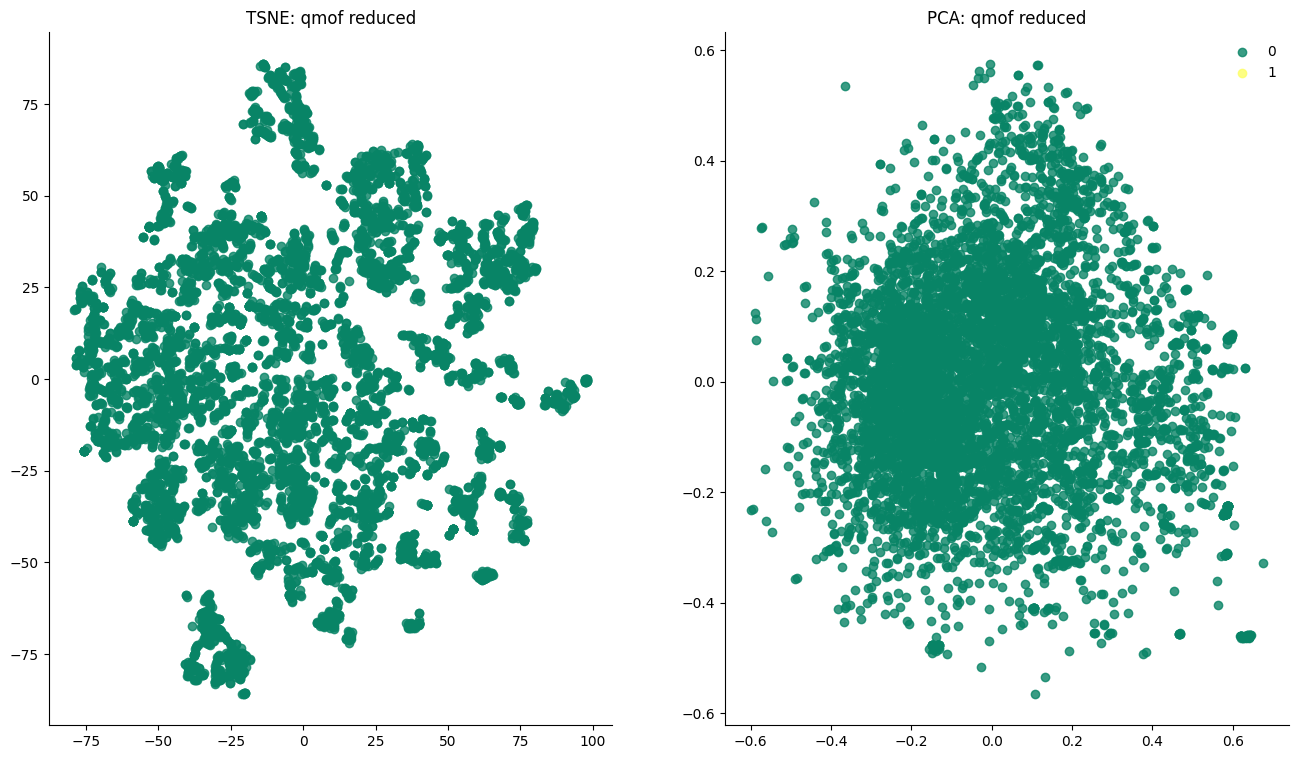

In [39]:
plot_2d(qmof_reduced, np.zeros((qmof_reduced.shape[0],)), "qmof reduced")
plt.savefig("tsne_reduce.svg")

# Classification

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    main_reduced, target.values.ravel(), test_size=0.2, random_state=42,
    stratify=target.values.ravel()
    )

scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
qmof_reduced_scaled = scaler.transform(qmof_reduced)

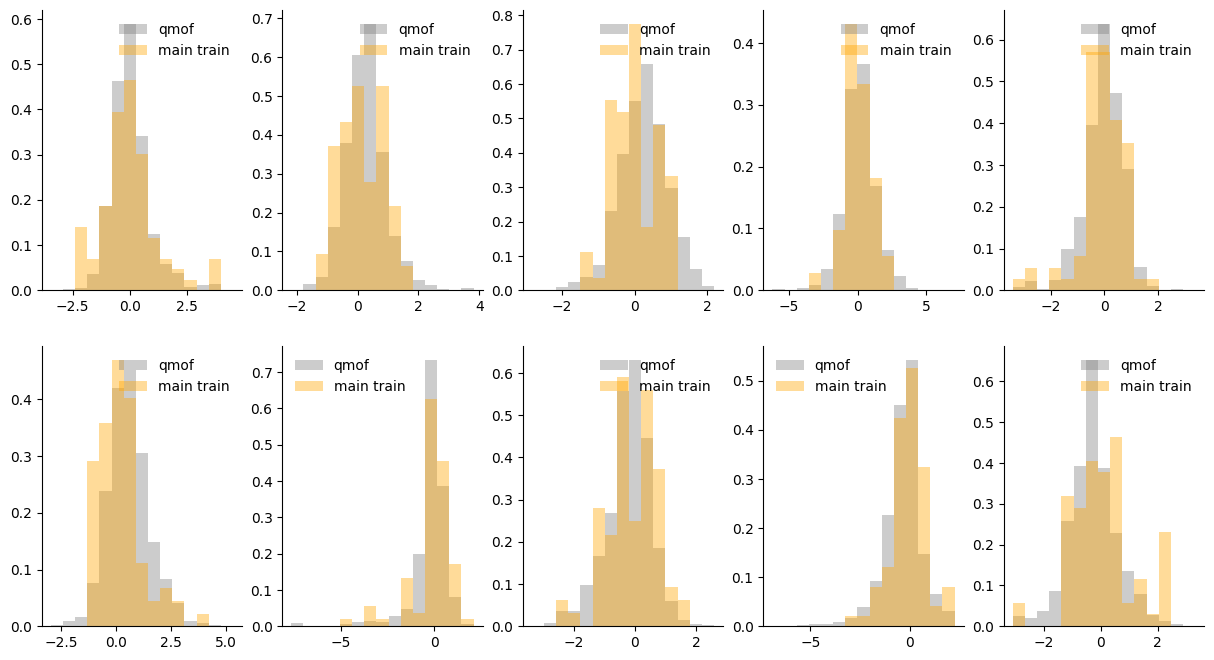

In [40]:
fig, axes = plt.subplots(2, 5, figsize=(15,8))
u=0
for i in range(2):
    for j in range(5):
        v, bins, p = axes[i,j].hist(qmof_reduced_scaled[:, u], density=True, bins=15, alpha=0.4, label="qmof", color='gray')
        axes[i,j].hist(X_train[:, u], density=True, bins=bins, alpha=0.4, label="main train", color='orange')
        axes[i,j].legend()
        u+=1
plt.savefig("distribution_scaled.svg")

In [17]:
c_model = ClassifierModel()
res = c_model.cv(pd.DataFrame(X_train), pd.DataFrame(y_train), time_per_clf=10)

evaluate CatBoost
  0%|          | 0/9223372036854775807 [00:00<?, ?trial/s, best loss=?]

  0%|          | 28/9223372036854775807 [00:10<956998799008831:08:48,  2.68trial/s, best loss: -0.6401515151515152] 
best depth ber folds: [9, 10, 12, 8, 12]
best n_estimators ber folds: [57, 54, 52, 45, 59]
best learning_rate ber folds: [2.603300229515629e-05, 4.4653621791694604e-05, 0.0004483332120001492, 7.019571597021232e-05, 3.369120690905726e-05]
best l2_leaf_reg ber folds: [0.17604448426851504, 0.12649540891003963, 0.13143230680609666, 0.19586071926793752, 0.04492277075696039]
evaluate RF
  0%|          | 61/9223372036854775807 [00:10<421861212157354:40:00,  6.07trial/s, best loss: -0.5431818181818183]
best max_depth ber folds: [10, 14, 15, 20, 17]
best n_estimators ber folds: [55, 81, 92, 52, 77]
evaluate AdaBoost
  0%|          | 72/9223372036854775807 [00:10<358883250762409:40:16,  7.14trial/s, best loss: -0.49621212121212127]
best max_depth ber folds: [9, 7, 11, 4, 12]
best n_estimators ber folds: [42, 55, 53, 48, 45]
best learning_rate ber folds: [0.00010755770098493603, 4.

In [18]:
res

{'CatBoost': {'depth': 9,
  'l2_leaf_reg': 0.17604448426851504,
  'learning_rate': 2.603300229515629e-05,
  'n_estimators': 57,
  'score': 0.8645276292335116,
  'balance': {'test': {'0.0': 10, '1.0': 7}, 'train': {'0.0': 39, '1.0': 25}}},
 'RF': {'max_depth': 15,
  'n_estimators': 92,
  'score': 0.8409090909090909,
  'balance': {'test': {'0.0': 10, '1.0': 6}, 'train': {'0.0': 39, '1.0': 26}}},
 'AdaBoost': {'learning_rate': 0.0005130779299203172,
  'max_depth': 11,
  'n_estimators': 53,
  'score': 0.7965587044534413,
  'balance': {'test': {'0.0': 10, '1.0': 6}, 'train': {'0.0': 39, '1.0': 26}}},
 'Knn': {'n_neighbors': 4,
  'score': 0.8645276292335116,
  'balance': {'test': {'0.0': 10, '1.0': 7}, 'train': {'0.0': 39, '1.0': 25}}}}

In [19]:
c_model.set_params({name: {param: res[name][param] for param in res[name] if param not in (
    "balance", "score")} for name in res})
c_model.fit(X_train, y_train)

In [20]:
for name in c_model.models:
    pred = c_model.models[name].predict(X_test)
    print(f"report for {name}: {c_model.score(y_test, pred):.2f}")
    print(metrics.classification_report(y_test, pred))

report for CatBoost: 0.85
              precision    recall  f1-score   support

         0.0       1.00      0.77      0.87        13
         1.0       0.73      1.00      0.84         8

    accuracy                           0.86        21
   macro avg       0.86      0.88      0.86        21
weighted avg       0.90      0.86      0.86        21

report for RF: 0.80
              precision    recall  f1-score   support

         0.0       0.91      0.77      0.83        13
         1.0       0.70      0.88      0.78         8

    accuracy                           0.81        21
   macro avg       0.80      0.82      0.81        21
weighted avg       0.83      0.81      0.81        21

report for AdaBoost: 0.68
              precision    recall  f1-score   support

         0.0       0.77      0.77      0.77        13
         1.0       0.62      0.62      0.62         8

    accuracy                           0.71        21
   macro avg       0.70      0.70      0.70        21
we

In [21]:
def roc_auc_plot(clf_model: ClassifierModel, x_test, y_test):
    plt.figure()
    lw = 2
    plt.plot()
    for clf in clf_model.models:
        pred_proba = clf_model.models[clf].predict_proba(x_test)
        fpr, tpr, threshold = metrics.roc_curve(y_test, pred_proba[:,1])
        auc = metrics.auc(fpr, tpr)
        plt.plot(fpr,
                 tpr,
                 label=f"ROC curve {clf} (area={auc:.2f})")
    plt.plot([0, 1], [0, 1], color="orange", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic example")
    plt.legend(loc="lower right")
    plt.show()

def roc_auc_plot_one(clf: object, x_test, y_test):
    plt.figure()
    lw = 2
    plt.plot()
    pred_proba = clf.predict_proba(x_test)
    fpr, tpr, threshold = metrics.roc_curve(y_test, pred_proba[:,1])
    auc = metrics.auc(fpr, tpr)
    plt.plot(fpr,
             tpr,
             label=f"ROC curve: (area={auc:.2f})")
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic example")
    plt.legend(loc="lower right")
    plt.show()

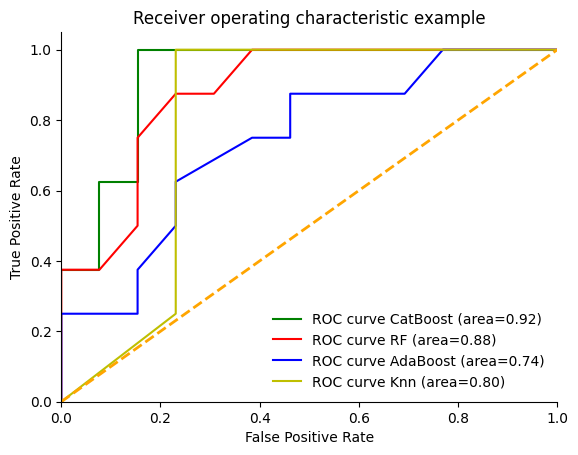

In [22]:
roc_auc_plot(c_model, X_test, y_test)

In [23]:
qmof_reduced = reduce_model.transform(reduce_model.dataset.cpu())

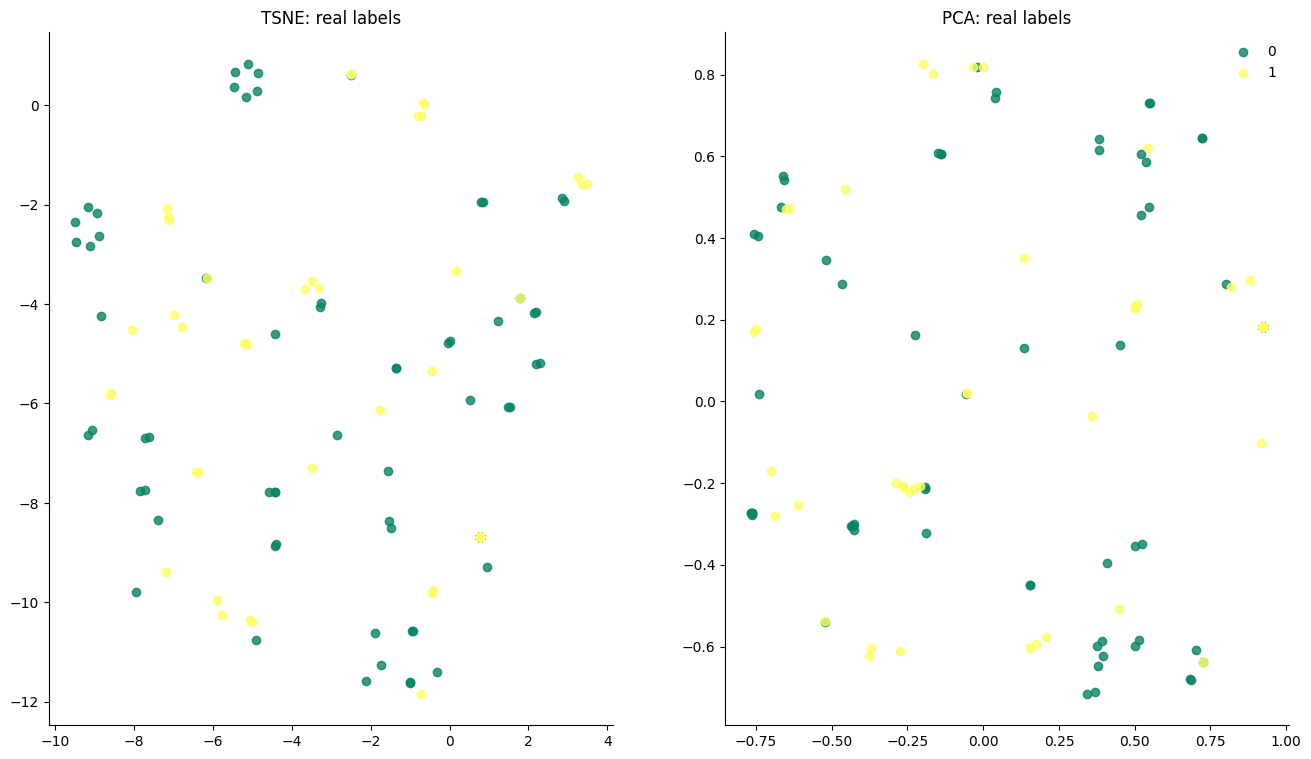

In [24]:
plot_2d(scaler.transform(main_reduced), target, "real labels")

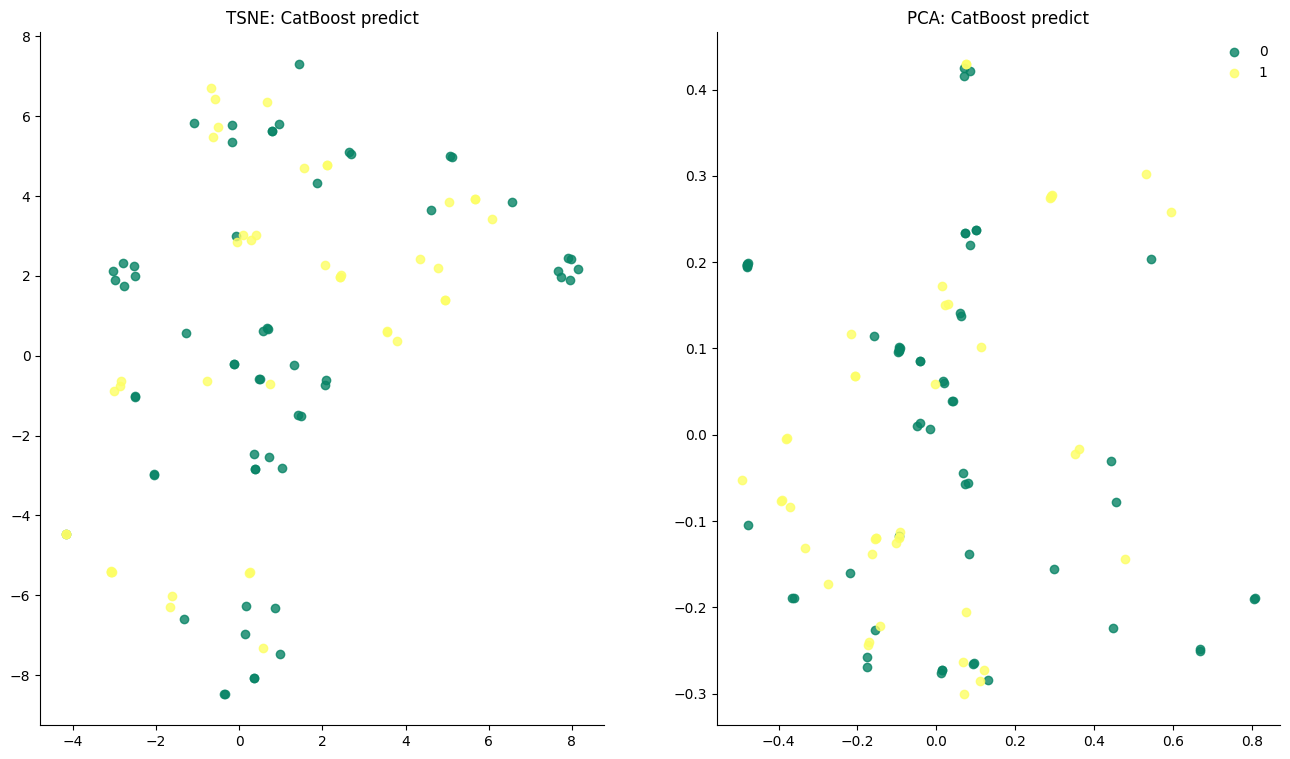

In [25]:
plot_2d(main_reduced, c_model.models["CatBoost"].predict(scaler.transform(main_reduced)), "CatBoost predict")

In [26]:
cat_ = np.array([*qmof_reduced, *main_reduced])

In [27]:
tsne = TSNE(n_components=2, random_state=0)
X_t = tsne.fit_transform(scaler.transform(cat_))
pca = PCA(n_components=2, random_state=0)
X_p = pca.fit_transform(scaler.transform(cat_))

In [28]:
xt_q = X_t[:qmof_reduced.shape[0]]
xp_q = X_p[:qmof_reduced.shape[0]]

xt_m = X_t[qmof_reduced.shape[0]:]
xp_m = X_p[qmof_reduced.shape[0]:]
pr_m = target.values.ravel()

In [29]:
pr_q = {name: c_model.models[name].predict_proba(qmof_reduced_scaled)[:,1] for name in c_model.models}

In [30]:
def colormap_plot(name):
    color = pr_q[name]

    figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 9))

    ax1.scatter(xt_q[:, 0], xt_q[:, 1], alpha=1, linewidths=0.1, edgecolors='black', c=color, cmap="summer")

    ax1.scatter(xt_m[pr_m == 0, 0], xt_m[pr_m == 0, 1], marker='v', edgecolors='black', color='green', s=50, label='no guest molecules (main)')
    ax1.scatter(xt_m[pr_m == 1, 0], xt_m[pr_m == 1, 1], marker='v', edgecolors='black', color='yellow', s=50, label='t-p molecules (main)')


    ax1.set_title(f"TSNE representation of predicted probability for {name}")
    map = ax2.scatter(xp_q[:, 0], xp_q[:, 1], marker='o', c=color, alpha=1, linewidths=0.1, edgecolors='black', cmap='summer')
    


    ax2.scatter(xp_m[pr_m == 0, 0], xp_m[pr_m == 0, 1], marker='v', edgecolors='black', color='green', s=50, label='no guest molecules (main)')
    ax2.scatter(xp_m[pr_m == 1, 0], xp_m[pr_m == 1, 1], marker='v', edgecolors='black', color='yellow', s=50,label='t-p (main)')

    ax2.set_title(f"PCA representation of predicted probability for {name}")
    ax2.legend()
    figure.colorbar(map)


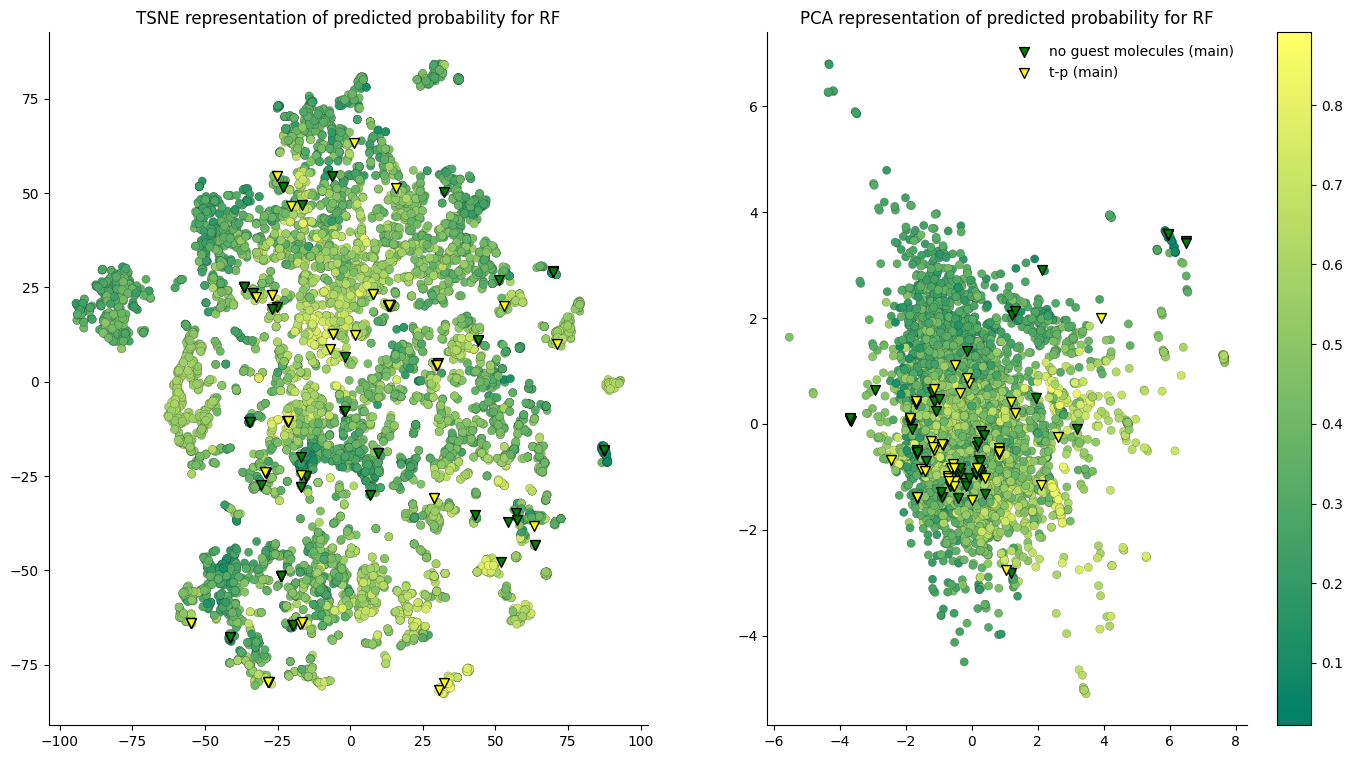

In [41]:
colormap_plot("RF")
plt.savefig("cmap_rf.svg")

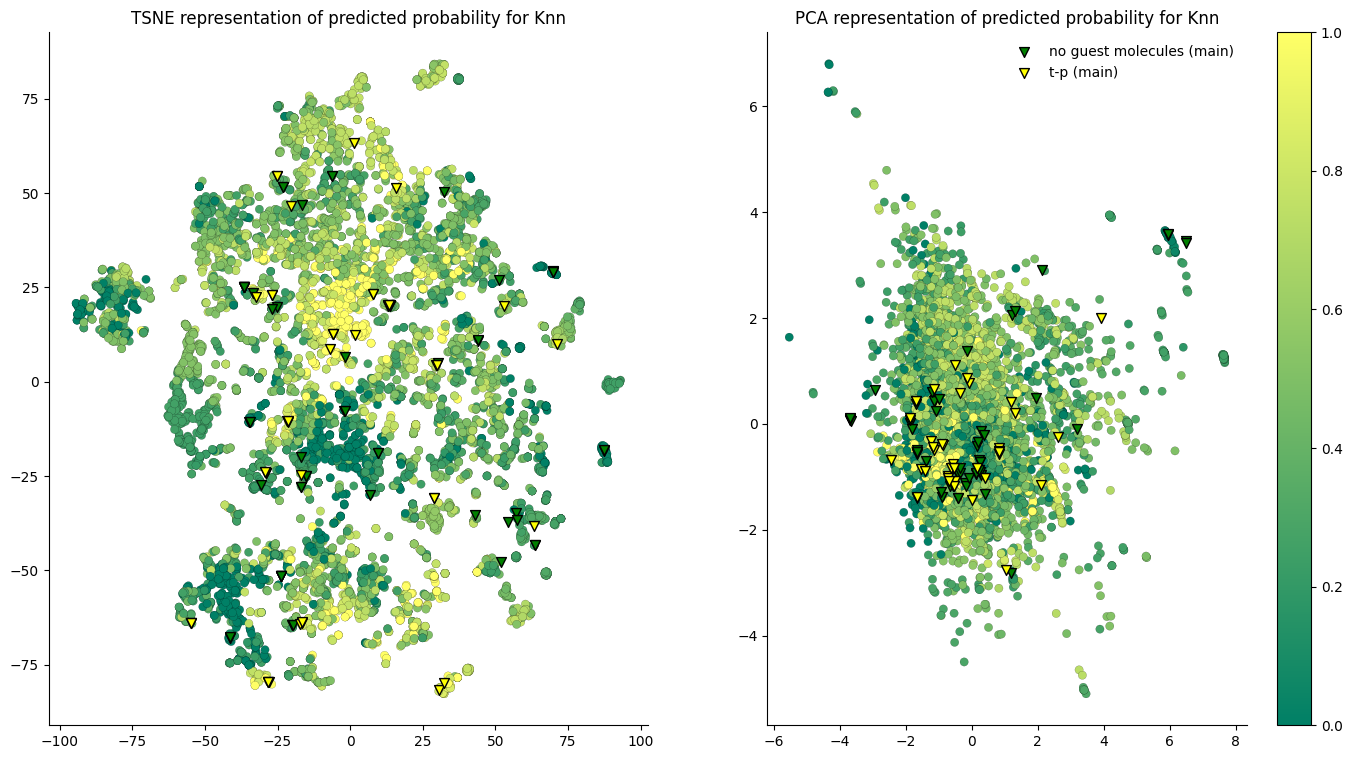

In [42]:
colormap_plot("Knn")
plt.savefig("cmap_knn.svg")

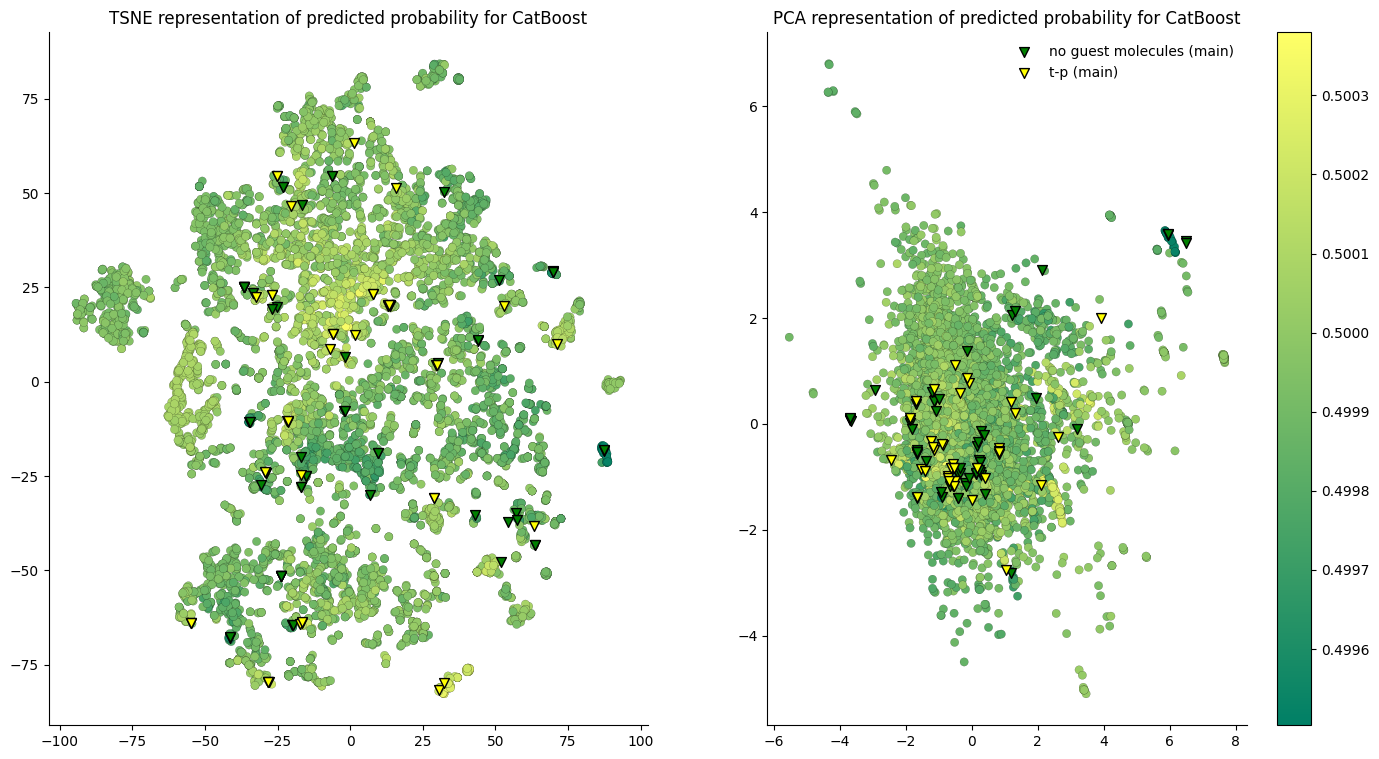

In [43]:
colormap_plot("CatBoost")
plt.savefig("cmap_catBoost.svg")

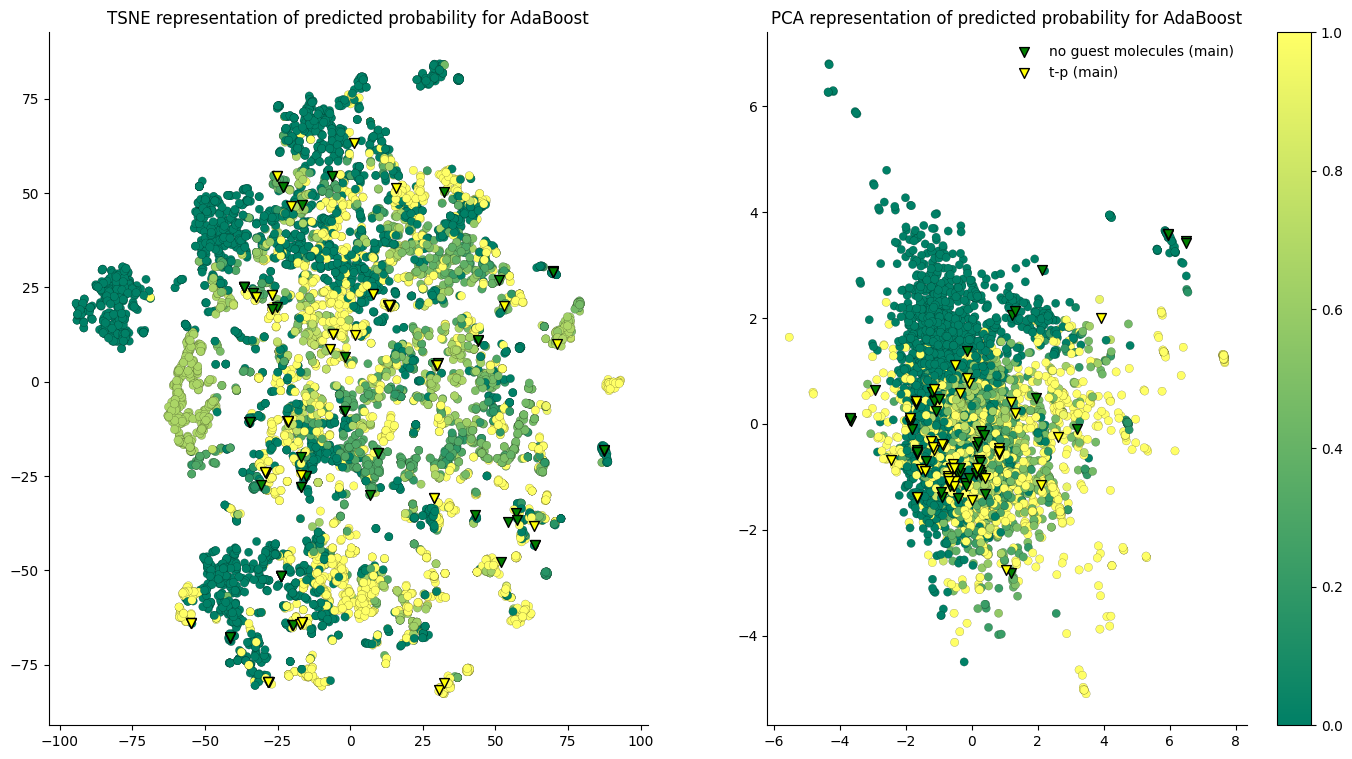

In [44]:
colormap_plot("AdaBoost")
plt.savefig("cmap_adaBoost.svg")

In [35]:
import joblib

joblib.dump(reduce_model, "best/reduce_model.pkl")

joblib.dump(c_model, "best/c_model.pkl")

joblib.dump(res, "best/best_params.pkl")


['best/best_params.pkl']